# Analysis of (Haber et al.)

We want to re-analyze the data from [*Haber et al. [2017]*](https://www.nature.com/articles/nature24489). 
The dataset contains cell compositions of the intestinal epithelium of mice under 4 conditions
(control, Salmonella infection, H. polygyrus infection (3 days), and H. polygyrus infection (10 days)).

In the original paper, differential abundance was tested via a Poisson regression model, 
not taking compositional effects into account.
We want to analyze whether the findings are consistent with scCODA.

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat

Load and format data: 

4 control samples, 2 samples for other conditions each; 8 cell types

In [2]:
cell_counts = pd.read_csv("../data/haber_counts.csv")

cell_counts["Condition"] = cell_counts["Mouse"].str.replace(r"_[0-9]", "")
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse", "Condition"])

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft     Condition  
0  125       191    18       Control  
1   11        40     5       C

Plot data for supplement:
Goblet cells seem like a good baseline for Salmonella (not much change)
For H. Polygyrus, take TA cells

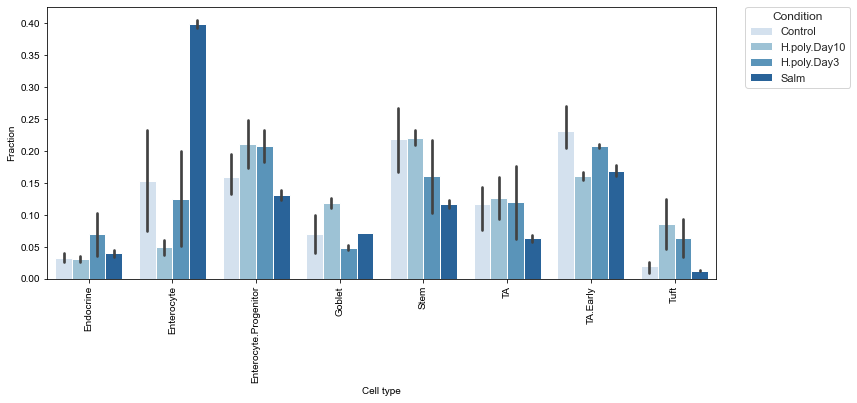

In [3]:
# Count data to ratios
counts = cell_counts.iloc[:, 1:-1]
rowsum = np.sum(counts, axis=1)

ratios = counts.div(rowsum, axis=0)
ratios["Condition"] = cell_counts["Condition"]

# Plot
fig, ax = plt.subplots(figsize=(12,5))
df = pd.melt(ratios, id_vars=['Condition'], value_vars=ratios.columns[:-1])
sns.set_context('notebook')
sns.set_style('ticks')
d = sns.barplot(x='variable', y = 'value', hue="Condition", data=df, palette="Blues")
d.set_ylabel('Fraction')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
plt.legend(bbox_to_anchor=(1.2, 1), borderaxespad=0., title="Condition")

plot_path = "../data/benchmark_results/"
plt.savefig(plot_path + "haber_bars_blue.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "haber_bars_blue.png", format="png", bbox_inches="tight")

plt.show()

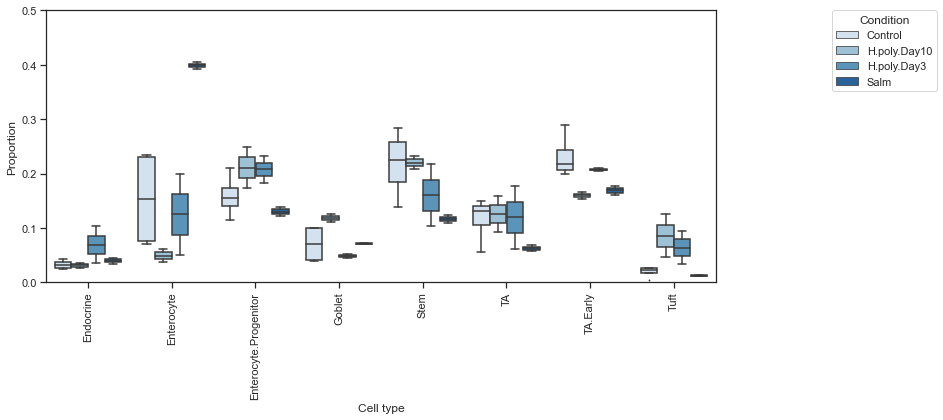

In [4]:
# Boxplots look a little better
fig, ax = plt.subplots(figsize=(12,5))
d = sns.boxplot(x='variable', y = 'value', hue=df["Condition"], data=df, fliersize=1,
               palette='Blues')

d.set_ylabel('Proportion')
loc, labels = plt.xticks()
d.set_xticklabels(labels, rotation=90)
d.set_xlabel('Cell type')
d.set_ylim([0,0.5])
plt.legend(bbox_to_anchor=(1.33, 1), borderaxespad=0., title="Condition")

plt.savefig(plot_path + "haber_boxes_blue.svg", format="svg", bbox_inches="tight")
plt.savefig(plot_path + "haber_boxes_blue.png", format="png", bbox_inches="tight")

plt.show()

Apply scCODA to Salmonella (baseline: Goblet cells)

--> Only Enterocytes are significant 

--> Haber et al: Enterocytes, Stem, TA, and TA (early) cells change

In [5]:
# model Salmonella
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]

model_salmonella = mod.CompositionalAnalysis(data_salm, formula="Condition", baseline_index="Goblet")
results_salmonella = model_salmonella.sample_hmc()

MCMC sampling finished. (54.687 sec)
Acceptance rate: 53.3%


In [6]:
results_salmonella.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Baseline index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.082        33.743847
Enterocyte                       2.310       115.214785
Enterocyte.Progenitor            2.516       141.570536
Goblet                           1.746        65.549008
Stem                             2.689       168.308412
TA                               2.101        93.484727
TA.Early                         2.861       199.896170
Tuft                             0.410        17.232516


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.000000        23.714319   
                  Enterocyte                    1.402444       329.153210   
        

Apply scCODA to H. Polygyrus 3 days (baseline: TA cells)

--> No significant changes in cell composition

--> Haber et al: Tuft cells change

In [7]:
# model H. polygyrus day 3
data_hp3 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day3"])]

model_hp3 = mod.CompositionalAnalysis(data_hp3, formula="Condition", baseline_index="TA")
results_hp3 = model_hp3.sample_hmc()

MCMC sampling finished. (57.429 sec)
Acceptance rate: 42.4%


In [8]:
results_hp3.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Baseline index: 5
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.709        41.308590
Enterocyte                       1.736       115.361477
Enterocyte.Progenitor            2.037       155.877506
Goblet                           1.060        58.678329
Stem                             2.187       181.103824
TA                               1.654       106.279294
TA.Early                         2.324       207.694963
Tuft                             0.291        27.196016


Effects:
                                                Final Parameter  \
Covariate                Cell Type                                
Condition[T.H.poly.Day3] Endocrine                          0.0   
                         Enterocyte                         0.0   
                         Enterocyte.Progenitor  

Apply scCODA to H. Polygyrus 10 days (baseline: TA cells)

--> Enterocytes and Tuft cells are significant 

--> Haber et al: Enterocytes, Goblet, Tuft, and TA (early) cells change

In [9]:
# model H. polygyrus day 10
data_hp10 = data_all[data_all.obs["Condition"].isin(["Control", "H.poly.Day10"])]

model_hp10 = mod.CompositionalAnalysis(data_hp10, formula="Condition", baseline_index="TA")
results_hp10 = model_hp10.sample_hmc()

MCMC sampling finished. (59.599 sec)
Acceptance rate: 57.1%


In [10]:
results_hp10.summary()

Compositional Analysis summary:

Data: 6 samples, 8 cell types
Baseline index: 5
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.707        37.816910
Enterocyte                       1.837       117.068165
Enterocyte.Progenitor            2.218       171.358246
Goblet                           1.417        76.919265
Stem                             2.448       215.671490
TA                               1.880       122.211893
TA.Early                         2.479       222.462015
Tuft                             0.418        28.325328


Effects:
                                                 Final Parameter  \
Covariate                 Cell Type                                
Condition[T.H.poly.Day10] Endocrine                     0.000000   
                          Enterocyte                   -0.750002   
                          Enterocyte.Progeni